<a href="https://colab.research.google.com/github/andiparjoleanu/FootballDetection/blob/main/DetectFootball.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Football Detection**

This Python script is designed to detect a football in video files, track its movement, and predict its trajectory. It automatically downloads a sample video (AVI format) for demonstration.

**1. Setup and libraries**  
Computer vision tasks are handled via the OpenCV (cv2) library. Once the environment is ready, this section reads the required .avi file from a public Google Drive.

In [102]:
import cv2
import numpy as np
import math
import csv

from google.colab import files
from collections import deque
from google.colab import drive
drive.mount('/content/drive')

input_video_path = '/content/drive/MyDrive/rgb.avi'
output_video_path = '/content/drive/MyDrive/2D_test_output.mp4'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**3. The 2D detection**  
This section performs the 2D football detection. It begins by opening the input video stream via the provided path and extracting its properties (width, height, fps), which are necessary to properly format the final output video.

In [103]:
#Open the video stream
video = cv2.VideoCapture(input_video_path)

if not video.isOpened():
    raise IOError("The video could not be opened.")

#Extract video properties
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = video.get(cv2.CAP_PROP_FPS)

if 0 in (width, height, fps):
    video.release()
    raise ValueError("The video file is empty or broken.")

#Initialize the VideoWriter, which builds the output video
#combined_width is the final width of the video including the 2D map
combined_width = width + height
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (combined_width, height))

The program attempts to detect the football in every frame using the following structure:

**2. A. Preprocessing**  
The computer needs to eliminate noise from an image to accurately detect an object. We resize the image for faster computation and apply a filter to each pixel to remove high-frequency noise. This filtering process is called convolution, which involves multiplying the value of each pixel by the corresponding value in the filter's matrix. We choose a Gaussian Filter because the Gaussian Curve emphasizes the value of the central pixel, creating a spherical effect in the filtered area. Thus, the circular shape of the ball is preserved, while smoothing the edges of sharp, straight objects (like grass or light glares). We choose the size of the filter as 11x11, large enough to smooth tiny shapes like grass and small enough to avoid blurring a ball (usually larger than 20 pixels wide).

In [104]:
def preprocess(frame):
    blurred_frame = cv2.GaussianBlur(frame, (11, 11), 0)
    return blurred_frame

**2. B. Color Segmentation**  
RGB images are hard to process in Computer Vision because of the mix between different colors and light. An HSV (Hue, Saturation, Value) map for any pixel is more convenient because it defines the default color of the pixel (the hue), the intensity of the color (the saturation), and the brightness (the value). In color theory, the hue is a circular 2D palette, which is 360 degrees. An 8-bit memory contains numbers up to 255, so the computer divides the circle in half, making the hue go from 0 to 179. Our ball is red, so we create an HSV mask which compares the pixel's color with the values of the red tones. According to the HSV scheme, the red tones sit between 0 and 10 (orange-reds) and also between 165 to 179 (pink-reds).

In [105]:
def red_segmentation(blurred_frame):
    hsv = cv2.cvtColor(blurred_frame, cv2.COLOR_BGR2HSV)

    # Considering the most intense orange-reds tones in the range
    start_orange_red = np.array([0, 150, 70])
    end_orange_red = np.array([10, 255, 255])

    # The function creates a black screen where only orange-reds are white
    orange_red_mask = cv2.inRange(hsv, start_orange_red, end_orange_red)

    # Considering the most intense pink-red tones in the range
    start_pink_red = np.array([165, 150, 70])
    end_pink_red = np.array([179, 255, 255])

    # This function creates a black screen where only pink-reds are white
    pink_red_mask = cv2.inRange(hsv, start_pink_red, end_pink_red)

    # Keeps the pixels that are white in either mask
    full_mask = cv2.bitwise_or(orange_red_mask, pink_red_mask)

    return full_mask

**2. C. Geometrical Filter**  
Theoretically, the program is currently able to identify all the red objects in the image. However, the detection algorithm must also take into consideration any situation where two or more red objects collide. If the ball is one of them, it will merge with another object and appear in the segmentation mask as part of a single, large blob.

To make the computer see the objects individually, the algorithm should implement the concepts of Erosion and Dilation. Erosion implies applying a filter with all-ones values on the segmentation mask to keep only the white pixels that have all white neighbors. This makes the objects shrink by (filter_size - 1) pixels in diameter. Dilation has the opposite behavior, but by applying it to the shrunken image, the thin connection between the objects doesn't build up again.




In [106]:
def clean_thin_connections(red_mask):
    # Use a 5x5 filter for erosion/dilation
    kernel = np.ones((5, 5), np.uint8)

    # Erode the white pixels to get rid of thin connections
    # Applying the filter twice ensures a better removal of thin connections
    eroded_mask = cv2.erode(red_mask, kernel, iterations=2)

    # Dilate the white pixels back so the objects regain their initial size
    final_mask = cv2.dilate(eroded_mask, kernel, iterations=2)

    return final_mask

The program must now apply the mask to the frame and filter the remaining red objects based on their size and shape. For each identified blob, the algorithm calculates the smallest bounding rectangle that encloses it to see if its size is in the desired range. After applying this initial filter, evaluating the aspect ratio and circularity of the blob concludes the detection. A round ball fits inside a perfect square box, so the program allows only shapes with proportions close to a square, while also taking into consideration that the ball may appear stretched due to motion blur. Furthermore, the circularity metric confirms that the shape inside the box is actually smooth and round. If all conditions are met, the function draws a green rectangular contour on the screen.

In [107]:
def detect_ball_2d(cleaned_mask, original_frame):
    # Find the outlines of all white blobs in the mask
    contours, _ = cv2.findContours(cleaned_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        # Measure the area of the current blob
        area = cv2.contourArea(contour)

        # Filter by size:
        # Ignore camera noise (< 100)
        if 225 < area:

            # Get the coordinates for drawing a rectangle around the object
            x, y, width, height = cv2.boundingRect(contour)

            # Prevent errors
            if height == 0:
                continue

            # Calculate the aspect ratio to approximate the shape
            aspect_ratio = float(width) / height

            # Measure the perimeter of the blob to calculate its circularity
            perimeter = cv2.arcLength(contour, True)

            if perimeter == 0:
                continue

            # Compute the shape's circularity
            circularity = 4 * np.pi * (area / (perimeter * perimeter))

            # Filter by shape:
            if 0.75 < aspect_ratio < 1.25 and circularity > 0.7:

                # Ball found
                # Calculate the center and radius of the ball.
                ((cx, cy), radius) = cv2.minEnclosingCircle(contour)

                # Draw a green bounding box on the frame
                cv2.rectangle(original_frame, (x, y), (x + width, y + height), (0, 255, 0), 2)

                # Draw a small green dot at the center of the box
                cv2.circle(original_frame, (int(cx), int(cy)), 3, (0, 255, 0), -1)

                # Return the updated frame, a success flag, and the ball's coordinates
                return original_frame, True, cx, cy, radius

    # If no object passed the filters, there is no ball found in the frame
    return original_frame, False, 0, 0, 0

The program generates the 2D detection by putting all the logic described above into a single loop, iterating through each frame in the video and drawing the resulting detections on them.

In [108]:
while True:
    ret, frame = video.read()
    if not ret:
        break

    # 1. Blur
    blurred = preprocess(frame)

    # 2. Color Mask
    red_mask = red_segmentation(blurred)

    # 3. Morphology
    cleaned_mask = clean_thin_connections(red_mask)

    # 4. Geometry & Drawing
    result_frame, ball_found, cx, cy, radius = detect_ball_2d(cleaned_mask, frame)

    out.write(result_frame)

video.release()
out.release()
cv2.destroyAllWindows()

The figures below present several frames captured from the final output video:

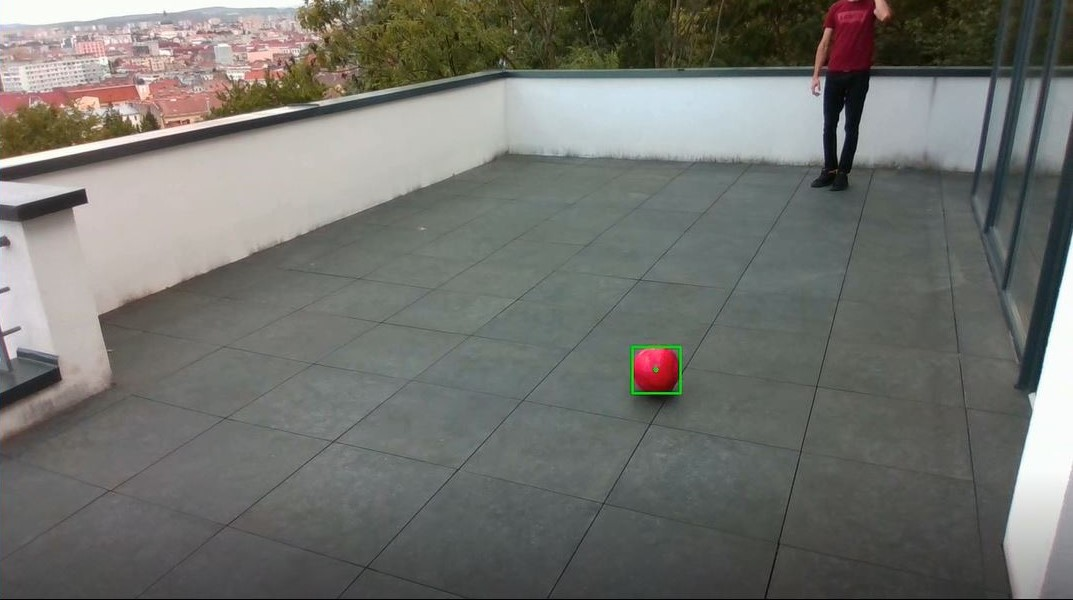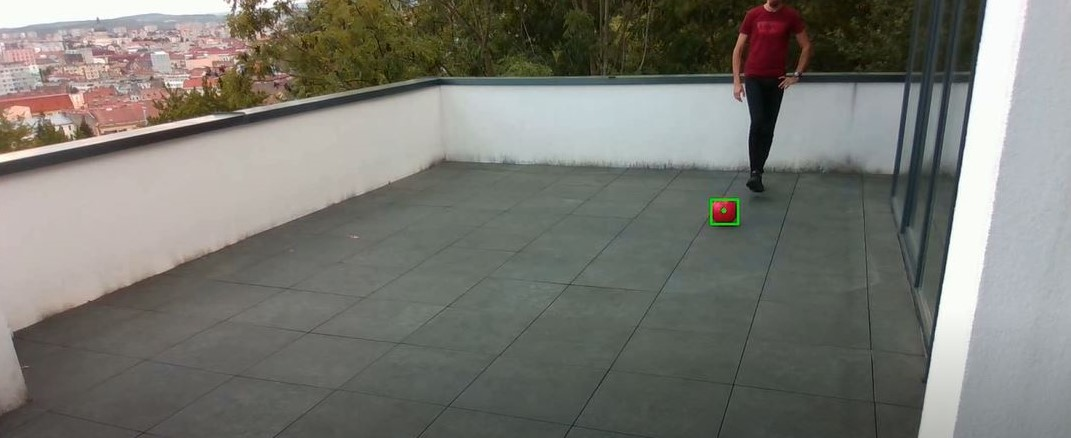


<p align='center'>Figure 1. Examples of successful 2D ball detection</p>

Some false-positive detections are visible too.

<p align="center">

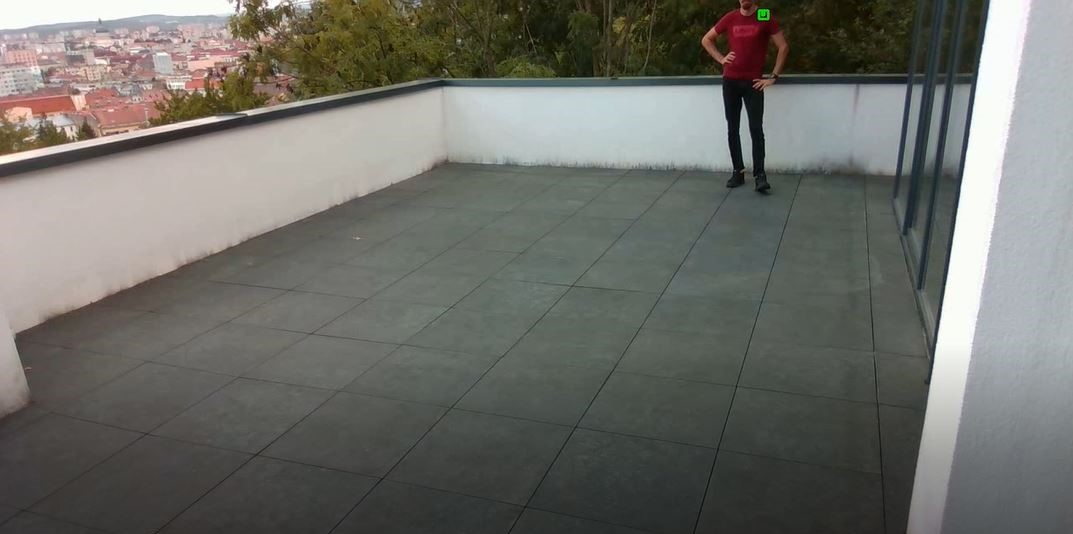

</p>

<p align='center'>Figure 2. False-positive detection</p>

**3. The 3D Detection**  
To translate the 2D pixel coordinates (cx​, cy​) and pixel radius into real-world 3D coordinates (X, Y, Z) in meters, the system uses the Pinhole Camera Model and the geometric principle of similar triangles.

Depth (Z) is determined using similar triangles formed by the camera lens, the physical ball, and the image sensor. The ratio of the ball's standard physical radius (R_real ​= 0.11 m) to its depth (Z) equals the ratio of its detected pixel radius (r_pixel​) to the focal length (F) (which tells the computer exactly how much the camera lens shrunk the giant 3D real object to make it fit onto your flat 2D screen).

The video was recorded using an Intel RealSense D435i camera, which has a known Horizontal Field of View (HFOV) of 69.4 degrees. Using the frame width (W in pixels), the focal length (F) is calculated as:

F = W/(2 ⋅ tan(HFOV/2​))

and the depth: Z = ​F ⋅ R_real/r_pixel​​

The horizontal (X) and vertical (Y) positions are calculated relative to the camera's optical center (0,0,0). By measuring the ball's pixel offset from the exact center of the frame (W_center​, H_center​), the real-world coordinates are projected as:  

X = ((cx​ − W_center​)⋅Z​)/F  
Y = ((cy​ − H_center​)⋅Z​)/F

The ratio of the ball's real-world horizontal position to its depth equals the ratio of its pixel offset from the center of the frame to the focal length.

While Z represents the forward depth, the absolute physical distance from the camera lens to the ball in 3D space is calculated using the formula:
Distance = sqrt(X^2 + Y^2 + Z^2)​

The spatial coordinates (X, Y, Z) and absolute distance are calculated for every frame where the ball is detected. This data is synchronized with a video timestamp and exported to a excel file for analysis. The trajectory the football is performing is indicated with a video overlay.

In [109]:
# Standard Size football radius in meters:
# A standard FIFA Size 5 football has a diameter of 22 cm (0.22 meters).
R_real = 0.11

# Intel RealSense D435i RGB Horizontal FOV is approximately 69.4 degrees
hfov_radians = math.radians(69.4)

# get video FPS to calculate the time
fps = video.get(cv2.CAP_PROP_FPS)

# Create a list for the Excel document with the headers:
trajectory_data = [["Time (s)", "X (m)", "Y (m)", "Z (m)", "Distance (m)"]]

frame_count = 0
output_csv = '3d_detection.csv'
deq = deque(maxlen=64)

# The 3D detection method
def calculate_3d_data(cx, cy, radius_pixel, frame_width, frame_height):
    # Calculate focal length based on video resolution
    focal_length = frame_width / (2 * math.tan(hfov_radians / 2))

    if radius_pixel == 0:
        return 0.0, 0.0, 0.0, 0.0

    # Pinhole Camera Math for X, Y, Z
    Z = (focal_length * R_real) / radius_pixel
    w_center = frame_width / 2.0
    h_center = frame_height / 2.0
    X = ((cx - w_center) * Z) / focal_length
    Y = ((cy - h_center) * Z) / focal_length

    # Euclidian Distance
    distance = math.sqrt(X**2 + Y**2 + Z**2)

    return X, Y, Z, distance

# Method for printing the distances to Excel
def save_to_csv(data, filename):
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(data)

After including the 3D detection methods and constants, the frame iteration from section 2 looks like this:

In [ ]:
while True:
    ret, frame = video.read()
    if not ret:
        break

    frame_count += 1

    # 1. Blur
    blurred = preprocess(frame)

    # 2. Color Mask
    red_mask = red_segmentation(blurred)

    # 3. Morphology
    cleaned_mask = clean_thin_connections(red_mask)

    # 4. Geometry & Drawing
    result_frame, ball_found, cx, cy, radius = detect_ball_2d(cleaned_mask, frame)

    if ball_found:

      # 5. 3D distance
      result = calculate_3d_data(cx, cy, radius, width, height)

      center = (int(cx), int(cy))
      deq.appendleft(center)

      if result:
          X, Y, Z, dist = result

          current_time = frame_count / fps

          trajectory_data.append([
              round(current_time, 3),
              round(X, 3),
              round(Y, 3),
              round(Z, 3),
              round(dist, 3)
          ])
    else:
      deq.appendleft(None)

    # Draw the current trajectory on the frame
    for i in range(1, len(deq)):
        if deq[i - 1] is None or deq[i] is None:
            continue

        # Calculate the thickness:
        # 64 is the maximum length of the trajectory
        # Dividing it and wrapping the result in sqrt() makes the thickness decrease smoothly from large to small.
        thickness = int(math.sqrt(64 / float(i + 1)) * 2.5)
        cv2.line(result_frame, deq[i - 1], deq[i], (0, 255, 0), thickness)

    # Write the frame on the output video file
    out.write(result_frame)

video.release()
out.release()
cv2.destroyAllWindows()

save_to_csv(trajectory_data, output_csv)
files.download(output_csv)

The system successfully maps the 2D pixel coordinates to 3D space. The resulting data follows the standard digital image convention, where the Y-axis is positive downwards and the X-axis is positive to the right, relative to the principal point (optical center).

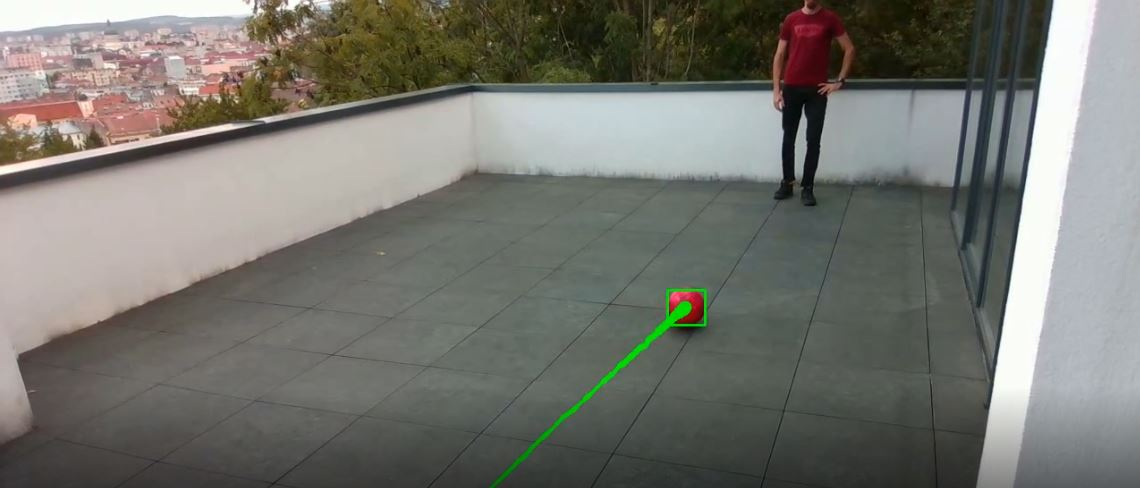

<p align='center'>Figure 3. Trajectory tracking</p>

**4. The 2D Map**  
So far, if the camera moves, the ball's coordinates change even if the ball is sitting still. To make the ball's position unaffected by the camera, we must pick a World Origin (0,0).

Thus, the program should do this math:   
World Position of Ball = Current Camera Position + Relative Distance to Ball

Ball's X on the map = x center + (meters * scale)
Ball's Z on the map = Z center - (meters * scale)
Minus because Z forward is "Up" on a map

To represent the map, meters are sclaed into pixels (1 meter = 50 pixels)


In [111]:
# Size of the map window in pixels
MAP_SIZE = height

# 1 meter = 50 pixels
SCALE = 50

map_center = MAP_SIZE // 2
map_deq = deque(maxlen=64)
map_canvas = np.zeros((MAP_SIZE, MAP_SIZE, 3), dtype=np.uint8)

# ball_x: meters right/left from camera
# ball_z: meters forward from camera
def draw_top_view(ball_x, ball_z, map_img, map_history):

    # 1. Clear the map (Black background)
    map_img.fill(0)

    # 2. Draw a Grid
    for i in range(0, MAP_SIZE, SCALE):
        cv2.line(map_img, (i, 0), (i, MAP_SIZE), (30, 30, 30), 1)
        cv2.line(map_img, (0, i), (MAP_SIZE, i), (30, 30, 30), 1)

    # Camera Position: always at center of this relative map
    cam_pos = (map_center, map_center)

    # Camera as a white dot
    cv2.circle(map_img, cam_pos, 8, (255, 255, 255), -1)
    cv2.putText(map_img, "CAM", (map_center + 10, map_center + 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)

    # Draw the trajectory on the map
    for i in range(1, len(map_history)):
        if map_history[i-1] is None or map_history[i] is None:
            continue

        # Draw a green line connecting historical points
        cv2.line(map_img, map_history[i-1], map_history[i], (0, 255, 0), 2)

    if ball_x is None or ball_z is None:
        return map_img

    # Ball Position
    bx_pixel = int(map_center + (ball_x * SCALE))
    bz_pixel = int(map_center - (ball_z * SCALE))

    ball_map_pos = (bx_pixel, bz_pixel)

    # Draw Ball
    # Green dot for Ball
    cv2.circle(map_img, ball_map_pos, 6, (0, 255, 0), -1)

    return map_img

The loop becomes:

In [112]:
while True:
    ret, frame = video.read()
    if not ret:
        break

    frame_count += 1

    # 1. Blur
    blurred = preprocess(frame)

    # 2. Color Mask
    red_mask = red_segmentation(blurred)

    # 3. Morphology
    cleaned_mask = clean_thin_connections(red_mask)

    # 4. Geometry & Drawing
    result_frame, ball_found, cx, cy, radius = detect_ball_2d(cleaned_mask, frame)

    curr_x = None
    curr_z = None

    if ball_found:

      # 5. 3D distance
      result = calculate_3d_data(cx, cy, radius, width, height)

      deq.appendleft((int(cx), int(cy)))

      if result:
          X, Y, Z, dist = result

          mx = int(map_center + (X * SCALE))
          mz = int(map_center - (Z * SCALE))
          map_deq.appendleft((mx, mz))

          current_time = frame_count / fps

          trajectory_data.append([
              round(current_time, 3),
              round(X, 3),
              round(Y, 3),
              round(Z, 3),
              round(dist, 3)
          ])


    else:
      map_deq.appendleft(None)
      deq.appendleft(None)

    # Draw the ball trajectory on the frame
    for i in range(1, len(deq)):
        if deq[i - 1] is None or deq[i] is None:
            continue

        thickness = int(math.sqrt(64 / float(i + 1)) * 2.5)
        cv2.line(result_frame, deq[i - 1], deq[i], (0, 255, 0), thickness)

    # 6. Draw the 2D Map
    map_frame = draw_top_view(curr_x, curr_z, map_canvas, map_deq)
    map_resized = cv2.resize(map_frame, (height, height))

    # Write the combine frame on the output video file
    combined = np.hstack((result_frame, map_resized))
    out.write(combined)

video.release()
out.release()
cv2.destroyAllWindows()

save_to_csv(trajectory_data, output_csv)
files.download(output_csv)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The resulting video demonstrates the application of the 2D map concept. The scene is rendered from a Bird's Eye View, eliminating camera depth distortions. As a result, the entire action is projected onto a flat plane, as if an observer were looking down perpendicularly at the center of the scene.

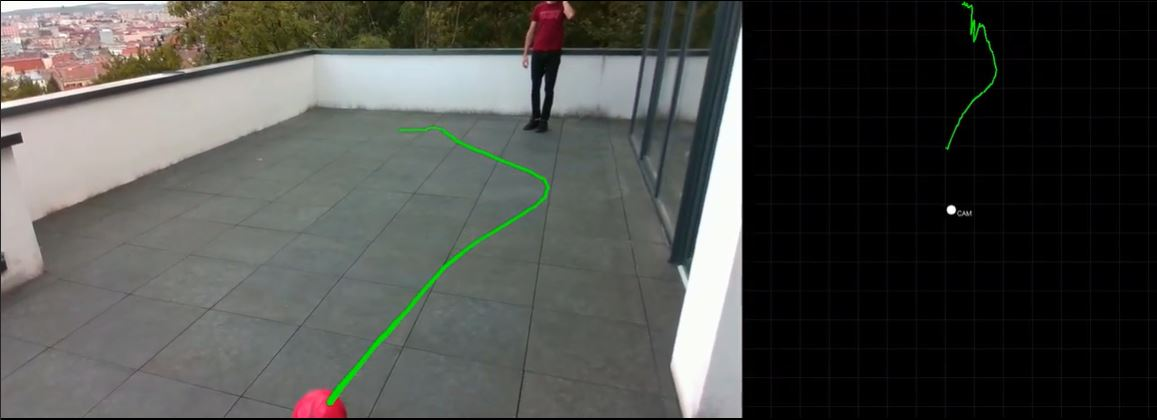

<p align='center'>Figure 4. 3D detection combined with 2D mapping</p>